Loaded checkpoint: Retro-4.ckpt

### Inference Result ###
Product:   CC(=O)Oc1ccccc1C(=O)O.CC(=O)O
Predicted Reactant(s): CC(=O)OC(C)=O.O=C(O)c1ccccc1O


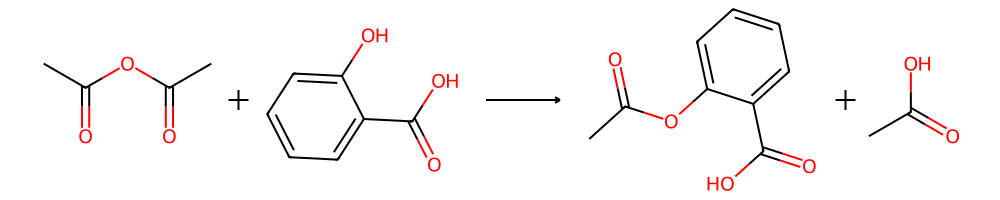

In [66]:
import torch
from vocab import Vocabulary
from model import TransformerModel
import rdkit 
from rdkit import Chem
from rdkit.Chem import Draw   

device = torch.device("cpu")
vocab = Vocabulary("data/Voc.txt")
model = TransformerModel(vocab).to(device)
ckpt_path = "Retro-4.ckpt"

# Load checkpoint BEFORE compiling
if ckpt_path is not None:
    state = torch.load(ckpt_path, map_location=device)

    # If keys contain _orig_mod, strip them
    fixed_state = {}
    for k, v in state.items():
        new_k = k.replace("_orig_mod.", "")  # remove wrapper prefix
        fixed_state[new_k] = v

    model.load_state_dict(fixed_state, strict=True)
    print(f"Loaded checkpoint: {ckpt_path}")

model.eval()

def encode_smiles(sm):
    tokens = vocab.tokenize(sm)
    ids = vocab.encode(tokens)
    return ids.unsqueeze(0).to(device)   # shape (1, seq_len)

def decode_ids(ids):
    ids = ids.squeeze(0).cpu().tolist()
    return vocab.decode(ids)


@torch.no_grad()
def predict(product_smiles, max_len=300, temperature=1.0):
    inp = encode_smiles(product_smiles)
    pred_ids = model.sample(inp, max_len=max_len, temperature=temperature)
    reactant = decode_ids(pred_ids)
    return reactant

"""
    Testing the model on products gotten from the synthesis of aspirin
    This exact SMILES sequence of the products is missing from the dataset 
    the model is trained on
"""

if __name__ == "__main__":
    product = "CC(=O)Oc1ccccc1C(=O)O.CC(=O)O"   #aspirin . acetic acid
    reactant = predict(product)

    print("\n### Inference Result ###")
    print("Product:  ", product)
    print("Predicted Reactant(s):", reactant)

from rdkit.Chem import rdChemReactions as Reactions
rxn = Reactions.ReactionFromSmarts(f"{reactant}>>{product}", useSmiles=True)
Draw.ReactionToImage(rxn)

## model able to predict salicylic acid and acetic anhydride